# HW 1 Part 2

## Visualize the optimization process

In [1]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
training_ds = datasets.MNIST(root="data", train=True, download=True, transform=ToTensor())
test_ds = datasets.MNIST(root='data', train=False, download=True, transform=ToTensor())
import pandas

In [2]:
# Setting default device

if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

display(f'{device} is available')

dtype = torch.float
torch.set_default_device(device)

'cuda is available'

In [3]:
class NMISTNetwork1(nn.Module):
        """First CNN for NMIST"""
        def __init__(self):
            super().__init__()
            self.seq = nn.Sequential(
            nn.Conv2d(1, 32, 5), 
            nn.ReLU(),
            nn.Flatten(1), 
            nn.Linear(18432, 128),
            nn.Linear(128, 10),
            )
        
        def forward(self, x):
              output = self.seq(x)
              return output

In [4]:
def nmist_train_loop(dataloader, model, loss_fn, optimize, epoch):
    """Training loop funciton for non-linear function"""
    model.train()
    num_batches = len(dataloader)
    train_loss, correct = 0,0
    size = len(dataloader.dataset)
        
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        optimize.zero_grad()
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        correct += (y_pred.argmax(dim=1) == y).type(torch.float).sum().item()
        loss.backward()

        grad_all = 0
        for params in model.parameters():
            grad = 0.0
            if params.grad is not None:
                grad = params.grad.detach().cpu().data.norm(2)
                grad_all += grad.item() ** 2
                #grad = (params.grad.cpu().data.numpy() ** 2).sum()
            #grad_all +=grad
        grad_norm = grad_all ** 0.5
        optimize.step()
    train_loss /= num_batches
    correct /=size
        
    weights = torch.Tensor().to(device)
    last_layer_wht = torch.Tensor().to(device)
    for name, params in model.named_parameters():
        if 'weight' in name:
            #print(name, len(params), params.shape)
            weights = torch.concat((weights, torch.nn.utils.parameters_to_vector(params).to(device)))
            last_layer_wht = torch.nn.utils.parameters_to_vector(params).to(device)

    return train_loss, correct, grad_norm, weights, last_layer_wht
        
def nmist_val_loop(dataloader, model, loss_fn, epoch):
    """Eval loop function for non-linear function"""
    model.eval()
    size= len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0,0

    with torch.no_grad():
        for X,y in dataloader:
            X = X.to(device)
            y_pred = model(X)
            test_loss += loss_fn(y_pred, y).item()
            correct += (y_pred.argmax(dim=1) == y).type(torch.float).sum().item()
    
    test_loss /= num_batches
    correct /=size
    return test_loss, correct

In [5]:
# nmist3 = NMISTNetwork3()
# nmist3.load_state_dict(torch.load('nmist3_weights.pth', weights_only=True))
df = pandas.DataFrame(columns=['epoch', 'training_event', 'weights'])

In [6]:
df = pandas.DataFrame(columns=['epoch', 'loss', 'accuracy', 'grad_norm'])

epoch_tracker = dict()
last_weight = dict()

weight_df = pandas.DataFrame()
layer_weight_df = pandas.DataFrame()
eight = 8

for training_event in range(eight):
    nmist1 = NMISTNetwork1()
    
    loss_fn = torch.nn.CrossEntropyLoss()
    
    lr = 1.5e-2
    batch_size=150
    max_epochs = 30
    #max_epochs = 5
    
    training_dl = DataLoader(training_ds, batch_size=batch_size)
    test_dl = DataLoader(test_ds, batch_size=batch_size)
    optimizer = torch.optim.SGD(nmist1.parameters(), lr=lr)
    
    epoch_df=pandas.DataFrame()
    layer_df = pandas.DataFrame()
    
    for epoch in range(max_epochs):
        loss, accuracy, grad_norm, weights, last_layer_wht = nmist_train_loop(training_dl, nmist1, loss_fn, optimizer, epoch)
        if training_event ==0:
            row = pandas.DataFrame([[epoch, loss, accuracy, grad_norm]], columns=['epoch','loss','accuracy', 'grad_norm'])
            if df.empty:
                df = row
            else:
                df = pandas.concat([df, row], ignore_index=True)
        
        with torch.no_grad():
            if epoch%3==0:
                epoch_df = pandas.concat((epoch_df, pandas.DataFrame(weights.detach().cpu().numpy()).T))
                layer_df = pandas.concat((layer_df, pandas.DataFrame(last_layer_wht.detach().cpu().numpy()).T))
                
                """if epoch in epoch_tracker:
                    epoch_tracker[epoch] = torch.concat((epoch_tracker[epoch], weights.unsqueeze(-1).T))
                else:
                    epoch_tracker[epoch] = weights.unsqueeze(-1).T
                    
                if epoch in last_weight:
                    last_weight[epoch] = torch.concat((last_weight[epoch], last_layer_wht.unsqueeze(-1).T))
                else:
                    last_weight[epoch] = last_layer_wht.unsqueeze(-1).T"""
                
            display(f"Training event {training_event} Epoch {epoch}. Train loss: {loss}. Accuracy: {accuracy}. Grad_Norm: {grad_norm}.")
    weight_df = pandas.concat((weight_df, epoch_df))
    layer_weight_df = pandas.concat((layer_weight_df, layer_df))
                                                   
        
    

'Training event 0 Epoch 0. Train loss: 0.6196342055127024. Accuracy: 0.8499833333333333. Grad_Norm: 2.009154821600593.'

'Training event 0 Epoch 1. Train loss: 0.32667160818353297. Accuracy: 0.9051166666666667. Grad_Norm: 1.999734685302314.'

'Training event 0 Epoch 2. Train loss: 0.2950356697104871. Accuracy: 0.9145333333333333. Grad_Norm: 1.89867054259575.'

'Training event 0 Epoch 3. Train loss: 0.2700532100815326. Accuracy: 0.92295. Grad_Norm: 1.749964858341028.'

'Training event 0 Epoch 4. Train loss: 0.245593881290406. Accuracy: 0.9298666666666666. Grad_Norm: 1.570215340516263.'

'Training event 0 Epoch 5. Train loss: 0.22056145844981073. Accuracy: 0.9377333333333333. Grad_Norm: 1.3887793798745152.'

'Training event 0 Epoch 6. Train loss: 0.19570406420622022. Accuracy: 0.9444833333333333. Grad_Norm: 1.2354816887360782.'

'Training event 0 Epoch 7. Train loss: 0.17245503864716738. Accuracy: 0.9510166666666666. Grad_Norm: 1.1251495037160908.'

'Training event 0 Epoch 8. Train loss: 0.15206688502803445. Accuracy: 0.95765. Grad_Norm: 1.0534831884167386.'

'Training event 0 Epoch 9. Train loss: 0.13504722378216683. Accuracy: 0.9627333333333333. Grad_Norm: 1.0084687614568906.'

'Training event 0 Epoch 10. Train loss: 0.12119553440250456. Accuracy: 0.9664833333333334. Grad_Norm: 0.9818023341259157.'

'Training event 0 Epoch 11. Train loss: 0.10999507867498323. Accuracy: 0.9695333333333334. Grad_Norm: 0.9673497426071761.'

'Training event 0 Epoch 12. Train loss: 0.10089096121257171. Accuracy: 0.9720833333333333. Grad_Norm: 0.9611073775315067.'

'Training event 0 Epoch 13. Train loss: 0.0934026269428432. Accuracy: 0.9741166666666666. Grad_Norm: 0.960002463290072.'

'Training event 0 Epoch 14. Train loss: 0.08714881448308005. Accuracy: 0.9758166666666667. Grad_Norm: 0.9612395034816938.'

'Training event 0 Epoch 15. Train loss: 0.08184610119555145. Accuracy: 0.9771. Grad_Norm: 0.9642963888036843.'

'Training event 0 Epoch 16. Train loss: 0.07729080623714253. Accuracy: 0.9784166666666667. Grad_Norm: 0.967236162384129.'

'Training event 0 Epoch 17. Train loss: 0.07332849367056042. Accuracy: 0.9797166666666667. Grad_Norm: 0.970100997200219.'

'Training event 0 Epoch 18. Train loss: 0.0698418764269445. Accuracy: 0.98065. Grad_Norm: 0.9727464237135905.'

'Training event 0 Epoch 19. Train loss: 0.06674366711522453. Accuracy: 0.9815666666666667. Grad_Norm: 0.9742235000737419.'

'Training event 0 Epoch 20. Train loss: 0.06396557710599154. Accuracy: 0.9821666666666666. Grad_Norm: 0.9759695855791655.'

'Training event 0 Epoch 21. Train loss: 0.06145427445531823. Accuracy: 0.9829666666666667. Grad_Norm: 0.9764614575376491.'

'Training event 0 Epoch 22. Train loss: 0.05916941000265069. Accuracy: 0.9832666666666666. Grad_Norm: 0.9773599168155571.'

'Training event 0 Epoch 23. Train loss: 0.05707711427472532. Accuracy: 0.9839166666666667. Grad_Norm: 0.9774477654419553.'

'Training event 0 Epoch 24. Train loss: 0.055146649513626474. Accuracy: 0.9844833333333334. Grad_Norm: 0.9766592110633168.'

'Training event 0 Epoch 25. Train loss: 0.0533570856845472. Accuracy: 0.9849166666666667. Grad_Norm: 0.9768682238655703.'

'Training event 0 Epoch 26. Train loss: 0.05168935949797742. Accuracy: 0.9853833333333334. Grad_Norm: 0.9769290258703598.'

'Training event 0 Epoch 27. Train loss: 0.050127906197449196. Accuracy: 0.9857833333333333. Grad_Norm: 0.9664767471688814.'

'Training event 0 Epoch 28. Train loss: 0.04866370098199695. Accuracy: 0.9862. Grad_Norm: 0.967319773672113.'

'Training event 0 Epoch 29. Train loss: 0.0472848587599583. Accuracy: 0.9866666666666667. Grad_Norm: 0.9678367305127055.'

'Training event 1 Epoch 0. Train loss: 0.6030321333184838. Accuracy: 0.8524666666666667. Grad_Norm: 1.9786005783907739.'

'Training event 1 Epoch 1. Train loss: 0.3269172725081444. Accuracy: 0.90505. Grad_Norm: 2.0485649043179706.'

'Training event 1 Epoch 2. Train loss: 0.29581555348820987. Accuracy: 0.9144333333333333. Grad_Norm: 1.9928619534403027.'

'Training event 1 Epoch 3. Train loss: 0.2704907939955592. Accuracy: 0.92255. Grad_Norm: 1.8738150901870423.'

'Training event 1 Epoch 4. Train loss: 0.24552352040074765. Accuracy: 0.9307333333333333. Grad_Norm: 1.711420599303861.'

'Training event 1 Epoch 5. Train loss: 0.22054720951244236. Accuracy: 0.9381666666666667. Grad_Norm: 1.530440066555834.'

'Training event 1 Epoch 6. Train loss: 0.19668047594372184. Accuracy: 0.9448833333333333. Grad_Norm: 1.3731532023269253.'

'Training event 1 Epoch 7. Train loss: 0.17514716081786902. Accuracy: 0.9509. Grad_Norm: 1.2616373316275158.'

'Training event 1 Epoch 8. Train loss: 0.15648234044667333. Accuracy: 0.95605. Grad_Norm: 1.1911119618960309.'

'Training event 1 Epoch 9. Train loss: 0.14071321526076644. Accuracy: 0.9613. Grad_Norm: 1.1420700780455815.'

'Training event 1 Epoch 10. Train loss: 0.1275614326656796. Accuracy: 0.9647. Grad_Norm: 1.105637923621906.'

'Training event 1 Epoch 11. Train loss: 0.11657792461337521. Accuracy: 0.9680666666666666. Grad_Norm: 1.0815348276716357.'

'Training event 1 Epoch 12. Train loss: 0.10732695061946287. Accuracy: 0.9704. Grad_Norm: 1.0620981939551037.'

'Training event 1 Epoch 13. Train loss: 0.09945946178399026. Accuracy: 0.97265. Grad_Norm: 1.0479988829058766.'

'Training event 1 Epoch 14. Train loss: 0.0926863473514095. Accuracy: 0.97435. Grad_Norm: 1.0380906988214156.'

'Training event 1 Epoch 15. Train loss: 0.08680582232540474. Accuracy: 0.9759166666666667. Grad_Norm: 1.0285847323831199.'

'Training event 1 Epoch 16. Train loss: 0.08166668773395941. Accuracy: 0.9772333333333333. Grad_Norm: 1.0223332672127878.'

'Training event 1 Epoch 17. Train loss: 0.07714568527298979. Accuracy: 0.9786166666666667. Grad_Norm: 1.0168966711599858.'

'Training event 1 Epoch 18. Train loss: 0.07314392606727779. Accuracy: 0.9798333333333333. Grad_Norm: 1.012547334331878.'

'Training event 1 Epoch 19. Train loss: 0.06958015052019619. Accuracy: 0.9807666666666667. Grad_Norm: 1.0090186070167737.'

'Training event 1 Epoch 20. Train loss: 0.0663861669274047. Accuracy: 0.9817. Grad_Norm: 1.0049100335487209.'

'Training event 1 Epoch 21. Train loss: 0.06350744527182542. Accuracy: 0.9825666666666667. Grad_Norm: 1.0042416211696819.'

'Training event 1 Epoch 22. Train loss: 0.0608980524726212. Accuracy: 0.9835. Grad_Norm: 1.0005188077047458.'

'Training event 1 Epoch 23. Train loss: 0.05851746981614269. Accuracy: 0.9842166666666666. Grad_Norm: 0.9971395479775117.'

'Training event 1 Epoch 24. Train loss: 0.05633546299301088. Accuracy: 0.9847. Grad_Norm: 0.9939783318948024.'

'Training event 1 Epoch 25. Train loss: 0.05432387111126445. Accuracy: 0.9852166666666666. Grad_Norm: 0.9903265228621817.'

'Training event 1 Epoch 26. Train loss: 0.052462012686301025. Accuracy: 0.9858. Grad_Norm: 0.9888736465473191.'

'Training event 1 Epoch 27. Train loss: 0.05073196286801249. Accuracy: 0.9862166666666666. Grad_Norm: 0.9864860117893096.'

'Training event 1 Epoch 28. Train loss: 0.04911644173262175. Accuracy: 0.9864666666666667. Grad_Norm: 0.9843842646518296.'

'Training event 1 Epoch 29. Train loss: 0.047602823033812455. Accuracy: 0.9869. Grad_Norm: 0.982949661175353.'

'Training event 2 Epoch 0. Train loss: 0.6476744548976421. Accuracy: 0.8429666666666666. Grad_Norm: 1.9260865157993192.'

'Training event 2 Epoch 1. Train loss: 0.329283832218498. Accuracy: 0.9032333333333333. Grad_Norm: 1.9201410208131453.'

'Training event 2 Epoch 2. Train loss: 0.2977700558491051. Accuracy: 0.9129833333333334. Grad_Norm: 1.8653572953775985.'

'Training event 2 Epoch 3. Train loss: 0.2725524568464607. Accuracy: 0.9216666666666666. Grad_Norm: 1.7809479003283266.'

'Training event 2 Epoch 4. Train loss: 0.24713174687698483. Accuracy: 0.9298666666666666. Grad_Norm: 1.6662781052139701.'

'Training event 2 Epoch 5. Train loss: 0.22067517654038965. Accuracy: 0.93745. Grad_Norm: 1.5224377126571356.'

'Training event 2 Epoch 6. Train loss: 0.1945046284236014. Accuracy: 0.94515. Grad_Norm: 1.3741726893447408.'

'Training event 2 Epoch 7. Train loss: 0.17052215162664652. Accuracy: 0.9516333333333333. Grad_Norm: 1.2573201944833323.'

'Training event 2 Epoch 8. Train loss: 0.14996624754276128. Accuracy: 0.9582333333333334. Grad_Norm: 1.1789242770337973.'

'Training event 2 Epoch 9. Train loss: 0.13309656145982443. Accuracy: 0.96255. Grad_Norm: 1.1342483073450862.'

'Training event 2 Epoch 10. Train loss: 0.11946552994661033. Accuracy: 0.96675. Grad_Norm: 1.1066762433424113.'

'Training event 2 Epoch 11. Train loss: 0.10845687777269632. Accuracy: 0.97015. Grad_Norm: 1.0903910732014372.'

'Training event 2 Epoch 12. Train loss: 0.09947965799132362. Accuracy: 0.97255. Grad_Norm: 1.0791783644443755.'

'Training event 2 Epoch 13. Train loss: 0.09205459692515433. Accuracy: 0.9748666666666667. Grad_Norm: 1.074488064837452.'

'Training event 2 Epoch 14. Train loss: 0.08581933774985373. Accuracy: 0.9766. Grad_Norm: 1.0720908808664373.'

'Training event 2 Epoch 15. Train loss: 0.08050647098571062. Accuracy: 0.9781166666666666. Grad_Norm: 1.0683763663000625.'

'Training event 2 Epoch 16. Train loss: 0.07592577870818787. Accuracy: 0.9791333333333333. Grad_Norm: 1.0633975686545618.'

'Training event 2 Epoch 17. Train loss: 0.07193007384659722. Accuracy: 0.9802833333333333. Grad_Norm: 1.0615903793721218.'

'Training event 2 Epoch 18. Train loss: 0.06841075757867657. Accuracy: 0.9810666666666666. Grad_Norm: 1.0577829545028838.'

'Training event 2 Epoch 19. Train loss: 0.06527877108077519. Accuracy: 0.9819. Grad_Norm: 1.0530807986483788.'

'Training event 2 Epoch 20. Train loss: 0.06246935548842884. Accuracy: 0.9827. Grad_Norm: 1.0469090183242136.'

'Training event 2 Epoch 21. Train loss: 0.05993089382187464. Accuracy: 0.9834833333333334. Grad_Norm: 1.043521960974193.'

'Training event 2 Epoch 22. Train loss: 0.05762512798071839. Accuracy: 0.984. Grad_Norm: 1.0368518662054742.'

'Training event 2 Epoch 23. Train loss: 0.055516006774269044. Accuracy: 0.98465. Grad_Norm: 1.0318534672260926.'

'Training event 2 Epoch 24. Train loss: 0.053576776169938965. Accuracy: 0.9852. Grad_Norm: 1.0248521399622474.'

'Training event 2 Epoch 25. Train loss: 0.051785505816806104. Accuracy: 0.9856833333333334. Grad_Norm: 1.0224000961047615.'

'Training event 2 Epoch 26. Train loss: 0.05012202582205646. Accuracy: 0.98625. Grad_Norm: 1.0181994926079556.'

'Training event 2 Epoch 27. Train loss: 0.04857048211502843. Accuracy: 0.98655. Grad_Norm: 1.0141526324329044.'

'Training event 2 Epoch 28. Train loss: 0.047118831870611756. Accuracy: 0.9868166666666667. Grad_Norm: 1.0087712321378066.'

'Training event 2 Epoch 29. Train loss: 0.04575397264328785. Accuracy: 0.9870666666666666. Grad_Norm: 1.005173285183489.'

'Training event 3 Epoch 0. Train loss: 0.6272207187861204. Accuracy: 0.8506. Grad_Norm: 1.8757467530162921.'

'Training event 3 Epoch 1. Train loss: 0.31780727855861185. Accuracy: 0.9079166666666667. Grad_Norm: 1.8441370852950936.'

'Training event 3 Epoch 2. Train loss: 0.27969624402001503. Accuracy: 0.9193. Grad_Norm: 1.728300225783229.'

'Training event 3 Epoch 3. Train loss: 0.24822983365505935. Accuracy: 0.9291166666666667. Grad_Norm: 1.56936521449779.'

'Training event 3 Epoch 4. Train loss: 0.21820244445465506. Accuracy: 0.93865. Grad_Norm: 1.3997060837772939.'

'Training event 3 Epoch 5. Train loss: 0.1902760365884751. Accuracy: 0.94615. Grad_Norm: 1.2629810571990772.'

'Training event 3 Epoch 6. Train loss: 0.16591982244513928. Accuracy: 0.9531833333333334. Grad_Norm: 1.1677157972444763.'

'Training event 3 Epoch 7. Train loss: 0.14578093339689077. Accuracy: 0.95905. Grad_Norm: 1.103812529372797.'

'Training event 3 Epoch 8. Train loss: 0.1296602228679694. Accuracy: 0.9638833333333333. Grad_Norm: 1.0644236720542095.'

'Training event 3 Epoch 9. Train loss: 0.1168774852878414. Accuracy: 0.9674666666666667. Grad_Norm: 1.0412590447350727.'

'Training event 3 Epoch 10. Train loss: 0.10660487907705829. Accuracy: 0.9705. Grad_Norm: 1.0287077243649003.'

'Training event 3 Epoch 11. Train loss: 0.0982193029508926. Accuracy: 0.9729666666666666. Grad_Norm: 1.0221557703781667.'

'Training event 3 Epoch 12. Train loss: 0.09124571724329143. Accuracy: 0.97475. Grad_Norm: 1.0181235042819898.'

'Training event 3 Epoch 13. Train loss: 0.08534288591006771. Accuracy: 0.9764166666666667. Grad_Norm: 1.0156630028486386.'

'Training event 3 Epoch 14. Train loss: 0.08027241634204983. Accuracy: 0.9775166666666667. Grad_Norm: 1.0139221009993402.'

'Training event 3 Epoch 15. Train loss: 0.07586016402463429. Accuracy: 0.9787166666666667. Grad_Norm: 1.0124111463536698.'

'Training event 3 Epoch 16. Train loss: 0.07197413634043187. Accuracy: 0.9798833333333333. Grad_Norm: 1.0108023842521043.'

'Training event 3 Epoch 17. Train loss: 0.06851814099936746. Accuracy: 0.9807833333333333. Grad_Norm: 1.0089647593396398.'

'Training event 3 Epoch 18. Train loss: 0.06542063363129273. Accuracy: 0.9816666666666667. Grad_Norm: 1.0068573551060063.'

'Training event 3 Epoch 19. Train loss: 0.06262596846790984. Accuracy: 0.9825166666666667. Grad_Norm: 1.0044742825010946.'

'Training event 3 Epoch 20. Train loss: 0.0600827870273497. Accuracy: 0.9831833333333333. Grad_Norm: 1.002101765572156.'

'Training event 3 Epoch 21. Train loss: 0.05775714784162119. Accuracy: 0.9838166666666667. Grad_Norm: 0.9998343053931222.'

'Training event 3 Epoch 22. Train loss: 0.05561764705576934. Accuracy: 0.9844666666666667. Grad_Norm: 0.9974428106024984.'

'Training event 3 Epoch 23. Train loss: 0.05364003594615497. Accuracy: 0.9851. Grad_Norm: 0.9952805473743381.'

'Training event 3 Epoch 24. Train loss: 0.051806315483991054. Accuracy: 0.9857. Grad_Norm: 0.9932361116697622.'

'Training event 3 Epoch 25. Train loss: 0.050099538384820334. Accuracy: 0.9862333333333333. Grad_Norm: 0.9914775136746744.'

'Training event 3 Epoch 26. Train loss: 0.04850222471693996. Accuracy: 0.9866166666666667. Grad_Norm: 0.9894956858444681.'

'Training event 3 Epoch 27. Train loss: 0.046999951220932416. Accuracy: 0.98695. Grad_Norm: 0.9877560772559013.'

'Training event 3 Epoch 28. Train loss: 0.045581663376651704. Accuracy: 0.9873. Grad_Norm: 0.9861355420746095.'

'Training event 3 Epoch 29. Train loss: 0.04424574786971789. Accuracy: 0.9876166666666667. Grad_Norm: 0.9851375205720768.'

'Training event 4 Epoch 0. Train loss: 0.6290319177508354. Accuracy: 0.8549666666666667. Grad_Norm: 1.908196003802876.'

'Training event 4 Epoch 1. Train loss: 0.32743437089025973. Accuracy: 0.90465. Grad_Norm: 1.9433478185096278.'

'Training event 4 Epoch 2. Train loss: 0.2971170849725604. Accuracy: 0.9139833333333334. Grad_Norm: 1.865336451279441.'

'Training event 4 Epoch 3. Train loss: 0.2726887221168727. Accuracy: 0.9225666666666666. Grad_Norm: 1.7385761545126288.'

'Training event 4 Epoch 4. Train loss: 0.24741046328097582. Accuracy: 0.9302833333333334. Grad_Norm: 1.5799847518422823.'

'Training event 4 Epoch 5. Train loss: 0.22025771827436982. Accuracy: 0.9382833333333334. Grad_Norm: 1.4099685826106647.'

'Training event 4 Epoch 6. Train loss: 0.1928974686609581. Accuracy: 0.9461. Grad_Norm: 1.2692804944963876.'

'Training event 4 Epoch 7. Train loss: 0.16794221498072148. Accuracy: 0.9530333333333333. Grad_Norm: 1.1733656414709752.'

'Training event 4 Epoch 8. Train loss: 0.1467500993050635. Accuracy: 0.9593. Grad_Norm: 1.1111908141376672.'

'Training event 4 Epoch 9. Train loss: 0.12951414976967499. Accuracy: 0.9643. Grad_Norm: 1.0736743303301894.'

'Training event 4 Epoch 10. Train loss: 0.11574201573617757. Accuracy: 0.9685333333333334. Grad_Norm: 1.0434500888053893.'

'Training event 4 Epoch 11. Train loss: 0.10470879631116986. Accuracy: 0.9715833333333334. Grad_Norm: 1.0211152372989485.'

'Training event 4 Epoch 12. Train loss: 0.09579113250365481. Accuracy: 0.9738833333333333. Grad_Norm: 1.0019632920420467.'

'Training event 4 Epoch 13. Train loss: 0.08847195815760642. Accuracy: 0.9759166666666667. Grad_Norm: 0.9868049903438622.'

'Training event 4 Epoch 14. Train loss: 0.08236648772377521. Accuracy: 0.9772833333333333. Grad_Norm: 0.9746049587006165.'

'Training event 4 Epoch 15. Train loss: 0.07718731435132213. Accuracy: 0.9786166666666667. Grad_Norm: 0.9644383102277777.'

'Training event 4 Epoch 16. Train loss: 0.07273805332835764. Accuracy: 0.9801333333333333. Grad_Norm: 0.9561611661817804.'

'Training event 4 Epoch 17. Train loss: 0.06886933853034861. Accuracy: 0.9811833333333333. Grad_Norm: 0.9489503528917468.'

'Training event 4 Epoch 18. Train loss: 0.06546672956552356. Accuracy: 0.98205. Grad_Norm: 0.942525763628213.'

'Training event 4 Epoch 19. Train loss: 0.062441459613619375. Accuracy: 0.9827833333333333. Grad_Norm: 0.9371243082361289.'

'Training event 4 Epoch 20. Train loss: 0.05973013655981049. Accuracy: 0.9835833333333334. Grad_Norm: 0.9333656858391521.'

'Training event 4 Epoch 21. Train loss: 0.05728296359418891. Accuracy: 0.9842833333333333. Grad_Norm: 0.9298705138602766.'

'Training event 4 Epoch 22. Train loss: 0.05505648647202179. Accuracy: 0.9849. Grad_Norm: 0.9278744779024587.'

'Training event 4 Epoch 23. Train loss: 0.05302042353898287. Accuracy: 0.9852333333333333. Grad_Norm: 0.9263913361468638.'

'Training event 4 Epoch 24. Train loss: 0.05114739562908653. Accuracy: 0.9858666666666667. Grad_Norm: 0.9260669143765101.'

'Training event 4 Epoch 25. Train loss: 0.04941532059398014. Accuracy: 0.9861666666666666. Grad_Norm: 0.9267779873491537.'

'Training event 4 Epoch 26. Train loss: 0.04780712424078956. Accuracy: 0.9865666666666667. Grad_Norm: 0.9276104019972333.'

'Training event 4 Epoch 27. Train loss: 0.04630725730385166. Accuracy: 0.9869166666666667. Grad_Norm: 0.9283164105950055.'

'Training event 4 Epoch 28. Train loss: 0.04490350551728625. Accuracy: 0.9873833333333333. Grad_Norm: 0.9297936525524457.'

'Training event 4 Epoch 29. Train loss: 0.04358599465689622. Accuracy: 0.9878333333333333. Grad_Norm: 0.9320792462703469.'

'Training event 5 Epoch 0. Train loss: 0.6015682923048735. Accuracy: 0.8526666666666667. Grad_Norm: 1.8446880038300357.'

'Training event 5 Epoch 1. Train loss: 0.32603259524330497. Accuracy: 0.90505. Grad_Norm: 1.926733195927652.'

'Training event 5 Epoch 2. Train loss: 0.29323720751330257. Accuracy: 0.9146833333333333. Grad_Norm: 1.8802255034928521.'

'Training event 5 Epoch 3. Train loss: 0.2657551505044103. Accuracy: 0.9238666666666666. Grad_Norm: 1.7702928111991119.'

'Training event 5 Epoch 4. Train loss: 0.23825913545675576. Accuracy: 0.9324833333333333. Grad_Norm: 1.6178105522034572.'

'Training event 5 Epoch 5. Train loss: 0.21083216913044453. Accuracy: 0.9403333333333334. Grad_Norm: 1.4524797380149823.'

'Training event 5 Epoch 6. Train loss: 0.18521538712084293. Accuracy: 0.9471833333333334. Grad_Norm: 1.3145362072847249.'

'Training event 5 Epoch 7. Train loss: 0.16289809407200664. Accuracy: 0.9541. Grad_Norm: 1.2206547267828118.'

'Training event 5 Epoch 8. Train loss: 0.14437125745695084. Accuracy: 0.9595. Grad_Norm: 1.160656320312836.'

'Training event 5 Epoch 9. Train loss: 0.1293376417737454. Accuracy: 0.9637666666666667. Grad_Norm: 1.1228106812558873.'

'Training event 5 Epoch 10. Train loss: 0.11718523061135784. Accuracy: 0.9675166666666667. Grad_Norm: 1.1008944822758053.'

'Training event 5 Epoch 11. Train loss: 0.10726984303444624. Accuracy: 0.97055. Grad_Norm: 1.0882727139219128.'

'Training event 5 Epoch 12. Train loss: 0.0990618439950049. Accuracy: 0.9727166666666667. Grad_Norm: 1.0812136310923837.'

'Training event 5 Epoch 13. Train loss: 0.09215795380994678. Accuracy: 0.9750166666666666. Grad_Norm: 1.0768749479468978.'

'Training event 5 Epoch 14. Train loss: 0.08626047694124281. Accuracy: 0.9766. Grad_Norm: 1.0740565533552495.'

'Training event 5 Epoch 15. Train loss: 0.08115608782507479. Accuracy: 0.97795. Grad_Norm: 1.070917996743059.'

'Training event 5 Epoch 16. Train loss: 0.07668982344912365. Accuracy: 0.9792. Grad_Norm: 1.0691790468490558.'

'Training event 5 Epoch 17. Train loss: 0.07274847535649315. Accuracy: 0.9801. Grad_Norm: 1.065973269815465.'

'Training event 5 Epoch 18. Train loss: 0.06924029939109459. Accuracy: 0.9808166666666667. Grad_Norm: 1.0641176236781282.'

'Training event 5 Epoch 19. Train loss: 0.0660986404272262. Accuracy: 0.9815833333333334. Grad_Norm: 1.0617962415788598.'

'Training event 5 Epoch 20. Train loss: 0.0632636456633918. Accuracy: 0.9822333333333333. Grad_Norm: 1.0590935428822774.'

'Training event 5 Epoch 21. Train loss: 0.060686254889005795. Accuracy: 0.98295. Grad_Norm: 1.053392239190293.'

'Training event 5 Epoch 22. Train loss: 0.05833243219414726. Accuracy: 0.9836666666666667. Grad_Norm: 1.0510519387677926.'

'Training event 5 Epoch 23. Train loss: 0.05617110502207652. Accuracy: 0.9842166666666666. Grad_Norm: 1.0475836907414564.'

'Training event 5 Epoch 24. Train loss: 0.05417886570212431. Accuracy: 0.98495. Grad_Norm: 1.0443356516330344.'

'Training event 5 Epoch 25. Train loss: 0.05233426718274131. Accuracy: 0.9854666666666667. Grad_Norm: 1.0414334174753512.'

'Training event 5 Epoch 26. Train loss: 0.050619319850811736. Accuracy: 0.9858333333333333. Grad_Norm: 1.038937365268948.'

'Training event 5 Epoch 27. Train loss: 0.049017933290451766. Accuracy: 0.9862. Grad_Norm: 1.036228119975707.'

'Training event 5 Epoch 28. Train loss: 0.047516483264043924. Accuracy: 0.9866. Grad_Norm: 1.0334453599986948.'

'Training event 5 Epoch 29. Train loss: 0.046102590914815667. Accuracy: 0.9870333333333333. Grad_Norm: 1.0311607983283455.'

'Training event 6 Epoch 0. Train loss: 0.6014973458275199. Accuracy: 0.8548833333333333. Grad_Norm: 1.990539582973781.'

'Training event 6 Epoch 1. Train loss: 0.3205824063718319. Accuracy: 0.9065833333333333. Grad_Norm: 1.9845472713522887.'

'Training event 6 Epoch 2. Train loss: 0.2866764933709055. Accuracy: 0.9171166666666667. Grad_Norm: 1.8707476830715473.'

'Training event 6 Epoch 3. Train loss: 0.2588231280539185. Accuracy: 0.9266. Grad_Norm: 1.7192299162842957.'

'Training event 6 Epoch 4. Train loss: 0.23192390909418464. Accuracy: 0.9346833333333333. Grad_Norm: 1.5512091790827436.'

'Training event 6 Epoch 5. Train loss: 0.2057026385050267. Accuracy: 0.9417833333333333. Grad_Norm: 1.3881630811003343.'

'Training event 6 Epoch 6. Train loss: 0.18133686777669936. Accuracy: 0.9489333333333333. Grad_Norm: 1.2630441591311232.'

'Training event 6 Epoch 7. Train loss: 0.1599179122550413. Accuracy: 0.9552666666666667. Grad_Norm: 1.1818453193265703.'

'Training event 6 Epoch 8. Train loss: 0.1418907136982307. Accuracy: 0.9602333333333334. Grad_Norm: 1.1327872072723304.'

'Training event 6 Epoch 9. Train loss: 0.1271137369866483. Accuracy: 0.9645166666666667. Grad_Norm: 1.1010123818380375.'

'Training event 6 Epoch 10. Train loss: 0.11512265474302694. Accuracy: 0.9684833333333334. Grad_Norm: 1.084049600854351.'

'Training event 6 Epoch 11. Train loss: 0.1053663805150427. Accuracy: 0.9713333333333334. Grad_Norm: 1.0743982657767541.'

'Training event 6 Epoch 12. Train loss: 0.09735208318335936. Accuracy: 0.9733333333333334. Grad_Norm: 1.0691625646405463.'

'Training event 6 Epoch 13. Train loss: 0.0906862543313764. Accuracy: 0.9749. Grad_Norm: 1.0646435225245414.'

'Training event 6 Epoch 14. Train loss: 0.085066842304077. Accuracy: 0.9765833333333334. Grad_Norm: 1.067108179129162.'

'Training event 6 Epoch 15. Train loss: 0.08026049035368488. Accuracy: 0.9779333333333333. Grad_Norm: 1.0635946234683995.'

'Training event 6 Epoch 16. Train loss: 0.07609828571323306. Accuracy: 0.9788666666666667. Grad_Norm: 1.064794220297678.'

'Training event 6 Epoch 17. Train loss: 0.07245008939527907. Accuracy: 0.9800166666666666. Grad_Norm: 1.0652644076992543.'

'Training event 6 Epoch 18. Train loss: 0.06921819782932288. Accuracy: 0.98075. Grad_Norm: 1.064761633107748.'

'Training event 6 Epoch 19. Train loss: 0.06632641509408131. Accuracy: 0.98155. Grad_Norm: 1.0655525628222862.'

'Training event 6 Epoch 20. Train loss: 0.06371573477634229. Accuracy: 0.9823166666666666. Grad_Norm: 1.0642555772531894.'

'Training event 6 Epoch 21. Train loss: 0.061339735480723905. Accuracy: 0.9830333333333333. Grad_Norm: 1.062753615298804.'

'Training event 6 Epoch 22. Train loss: 0.05916386571712792. Accuracy: 0.9836666666666667. Grad_Norm: 1.0605967283384332.'

'Training event 6 Epoch 23. Train loss: 0.05715852205292322. Accuracy: 0.9842166666666666. Grad_Norm: 1.0577464780776518.'

'Training event 6 Epoch 24. Train loss: 0.055303348822053525. Accuracy: 0.9848833333333333. Grad_Norm: 1.0562839763634306.'

'Training event 6 Epoch 25. Train loss: 0.05357625879580155. Accuracy: 0.9852. Grad_Norm: 1.0540761690919183.'

'Training event 6 Epoch 26. Train loss: 0.05196271594963037. Accuracy: 0.9857666666666667. Grad_Norm: 1.0514083021430947.'

'Training event 6 Epoch 27. Train loss: 0.05044811956293415. Accuracy: 0.98625. Grad_Norm: 1.0491315832789105.'

'Training event 6 Epoch 28. Train loss: 0.04902165646781213. Accuracy: 0.9866166666666667. Grad_Norm: 1.0465493136060868.'

'Training event 6 Epoch 29. Train loss: 0.04767376099422108. Accuracy: 0.9868833333333333. Grad_Norm: 1.0440615178471309.'

'Training event 7 Epoch 0. Train loss: 0.6877191464789212. Accuracy: 0.83635. Grad_Norm: 1.9882461530107114.'

'Training event 7 Epoch 1. Train loss: 0.3290954978018999. Accuracy: 0.90405. Grad_Norm: 2.0041374474309053.'

'Training event 7 Epoch 2. Train loss: 0.29554181337356566. Accuracy: 0.9141833333333333. Grad_Norm: 1.9301241327431156.'

'Training event 7 Epoch 3. Train loss: 0.2685689236223698. Accuracy: 0.9230833333333334. Grad_Norm: 1.8061199111799409.'

'Training event 7 Epoch 4. Train loss: 0.24155810399912298. Accuracy: 0.9312833333333334. Grad_Norm: 1.643150227336494.'

'Training event 7 Epoch 5. Train loss: 0.21420125694014133. Accuracy: 0.9393833333333333. Grad_Norm: 1.4682466502958877.'

'Training event 7 Epoch 6. Train loss: 0.18823067730292678. Accuracy: 0.9464166666666667. Grad_Norm: 1.321330237188937.'

'Training event 7 Epoch 7. Train loss: 0.1652780665596947. Accuracy: 0.9529333333333333. Grad_Norm: 1.22363188691068.'

'Training event 7 Epoch 8. Train loss: 0.14598629588726908. Accuracy: 0.9588166666666667. Grad_Norm: 1.1656345083772088.'

'Training event 7 Epoch 9. Train loss: 0.13024667986668648. Accuracy: 0.9636666666666667. Grad_Norm: 1.1322856604938119.'

'Training event 7 Epoch 10. Train loss: 0.11752285411814228. Accuracy: 0.96725. Grad_Norm: 1.1164126375212071.'

'Training event 7 Epoch 11. Train loss: 0.10718938361620531. Accuracy: 0.9701166666666666. Grad_Norm: 1.1117152921524347.'

'Training event 7 Epoch 12. Train loss: 0.09870061559835448. Accuracy: 0.9723166666666667. Grad_Norm: 1.112506209612936.'

'Training event 7 Epoch 13. Train loss: 0.09162995451362804. Accuracy: 0.97435. Grad_Norm: 1.1163044486737608.'

'Training event 7 Epoch 14. Train loss: 0.08565591276157647. Accuracy: 0.9763833333333334. Grad_Norm: 1.121020422554041.'

'Training event 7 Epoch 15. Train loss: 0.08054299285169692. Accuracy: 0.97775. Grad_Norm: 1.1251083584080808.'

'Training event 7 Epoch 16. Train loss: 0.07610770285129548. Accuracy: 0.97895. Grad_Norm: 1.1284131675147004.'

'Training event 7 Epoch 17. Train loss: 0.07221361490432172. Accuracy: 0.97995. Grad_Norm: 1.130041556797288.'

'Training event 7 Epoch 18. Train loss: 0.06876108885626309. Accuracy: 0.9808333333333333. Grad_Norm: 1.1341701752457456.'

'Training event 7 Epoch 19. Train loss: 0.06567175404750741. Accuracy: 0.9815666666666667. Grad_Norm: 1.134093150026902.'

'Training event 7 Epoch 20. Train loss: 0.0628833527979441. Accuracy: 0.9824666666666667. Grad_Norm: 1.133193358517743.'

'Training event 7 Epoch 21. Train loss: 0.060353306949837135. Accuracy: 0.9832666666666666. Grad_Norm: 1.1312159699544773.'

'Training event 7 Epoch 22. Train loss: 0.05804267523577437. Accuracy: 0.984. Grad_Norm: 1.1297861909626858.'

'Training event 7 Epoch 23. Train loss: 0.05591986832907423. Accuracy: 0.9845333333333334. Grad_Norm: 1.1276200320117218.'

'Training event 7 Epoch 24. Train loss: 0.05395977872773074. Accuracy: 0.9851333333333333. Grad_Norm: 1.1261864369003678.'

'Training event 7 Epoch 25. Train loss: 0.05214334277785383. Accuracy: 0.9857. Grad_Norm: 1.124406554459776.'

'Training event 7 Epoch 26. Train loss: 0.05045253038755618. Accuracy: 0.9859833333333333. Grad_Norm: 1.1226586065954238.'

'Training event 7 Epoch 27. Train loss: 0.04887613542261533. Accuracy: 0.9865166666666667. Grad_Norm: 1.118243492008034.'

'Training event 7 Epoch 28. Train loss: 0.04739080499042757. Accuracy: 0.9868833333333333. Grad_Norm: 1.1195467851756182.'

'Training event 7 Epoch 29. Train loss: 0.04600098904746119. Accuracy: 0.9872833333333333. Grad_Norm: 1.1184391736500403.'

In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2) 
reduced_dimension = pandas.DataFrame(pca.fit_transform(weight_df.to_numpy()), columns = ['x','y'] )
reduced_dimension

epoch_num = [x for x in range(max_epochs) if x%3 == 0] * eight
reduced_dimension['epoch'] = epoch_num
reduced_dimension['iteration'] = [y for y in range(eight) for x in [e for e in range(max_epochs) if e%3==0]]

reduced_dimension

layer_reduced_dimension = pandas.DataFrame(pca.fit_transform(layer_weight_df.to_numpy()), columns = ['x','y'] )
layer_reduced_dimension['epoch'] = epoch_num
layer_reduced_dimension['iteration'] = [y for y in range(eight) for x in [e for e in range(max_epochs) if e%3==0]]
layer_reduced_dimension, reduced_dimension

(           x         y  epoch  iteration
 0  -0.318119  0.456390      0          0
 1  -0.364998  0.497525      3          0
 2  -0.410951  0.538137      6          0
 3  -0.459227  0.578600      9          0
 4  -0.498865  0.612469     12          0
 ..       ...       ...    ...        ...
 75 -2.130494 -0.644679     15          7
 76 -2.218007 -0.675248     18          7
 77 -2.291676 -0.699614     21          7
 78 -2.355535 -0.719881     24          7
 79 -2.412187 -0.737316     27          7
 
 [80 rows x 4 columns],
            x         y  epoch  iteration
 0   1.078545  1.281306      0          0
 1   1.169169  1.374613      3          0
 2   1.254438  1.467205      6          0
 3   1.319402  1.547379      9          0
 4   1.363364  1.605947     12          0
 ..       ...       ...    ...        ...
 75  0.096941 -4.742828     15          7
 76  0.099498 -4.837626     18          7
 77  0.101827 -4.914970     21          7
 78  0.103878 -4.980137     24          7
 79  0.1

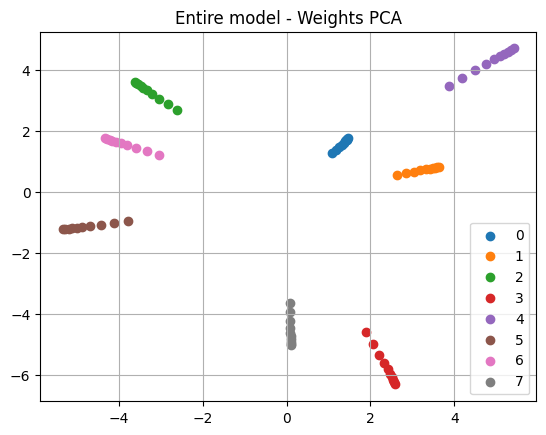

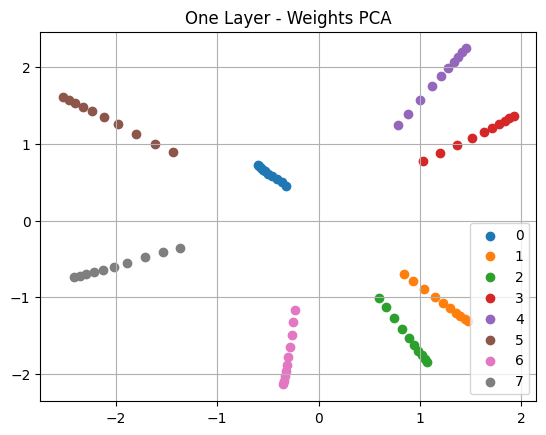

In [8]:
fig, ax = plt.subplots()
for key in reduced_dimension.iteration.unique():
    dots = reduced_dimension[reduced_dimension.iteration == key]
    ax.scatter(dots.x, dots.y, label=key)
ax.legend()
ax.grid(True)
plt.title('Entire model - Weights PCA')

fig2, ax2 = plt.subplots()
for key in layer_reduced_dimension.iteration.unique():
    dots = layer_reduced_dimension[layer_reduced_dimension.iteration == key]
    ax2.scatter(dots.x, dots.y, label=key)
ax2.legend()
ax2.grid(True)
plt.title('One Layer - Weights PCA')
plt.show()


In [9]:
#torch.concat( (torch.stack((weights, weights)), weights.unsqueeze(-1).T))
#with torch.no_grad():
#    display(weights.unsqueeze(-1).T.shape)
#fig, ax = plt.subplots()
#for key in epoch_tracker:
#    with torch.no_grad():
#        U,S,V = torch.pca_lowrank(epoch_tracker[key], center=True, q=2)
#        S=S.detach().cpu().numpy()
#        ax.scatter(S[0], S[1], label=key)
#ax.legend()
#ax.grid(True)
#plt.show()

"""fig2, ax2 = plt.subplots()
for key in last_weight:
    with torch.no_grad():
        U,S,V = torch.pca_lowrank(last_weight[key], center=True, q=2)
        S=S.detach().cpu().numpy()
        ax2.scatter(S[0], S[1], label=key)
ax2.legend()
ax2.grid(True)
plt.show()"""
print()

array([<Axes: xlabel='epoch'>, <Axes: xlabel='epoch'>], dtype=object)

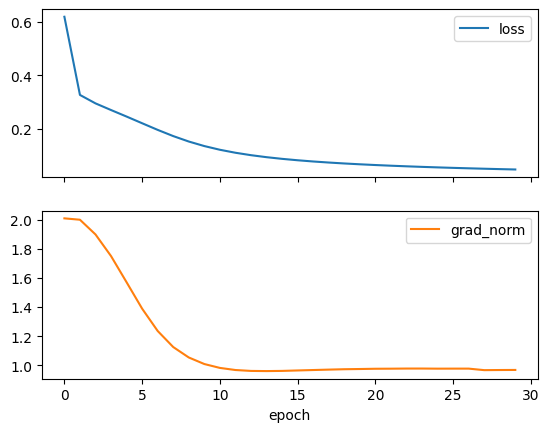

In [10]:
df.plot(x='epoch', y=['loss','grad_norm'], subplots=True)

In [11]:
df

,epoch,loss,accuracy,grad_norm
0,0,0.619634,0.849983,2.009155
1,1,0.326672,0.905117,1.999735
2,2,0.295036,0.914533,1.898671
3,3,0.270053,0.922950,1.749965
4,4,0.245594,0.929867,1.570215
5,5,0.220561,0.937733,1.388779
6,6,0.195704,0.944483,1.235482
7,7,0.172455,0.951017,1.125150
8,8,0.152067,0.957650,1.053483
9,9,0.135047,0.962733,1.008469
